# Retail Theft Trend Analysis (POLICY-01)

**Objective:** Evaluate the 5-year retail theft trend and provide an evidence-based verdict on the "retail theft crisis" narrative.

## Overview

This notebook analyzes Philadelphia theft incident data to:
1. Calculate annual theft trends from 2018-2024
2. Compare current levels to the 2018-2019 baseline
3. Identify seasonal patterns
4. Provide a SUPPORTED/NOT SUPPORTED verdict based on configured threshold (25%)

**Outputs:**
- `reports/retail_theft_trend.png` - 5-year trend visualization
- `reports/retail_theft_verdict.md` - Verdict summary with methodology

In [1]:
# Parameters (can be injected by papermill)
VERSION = "v1.0"
FAST_MODE = False

In [2]:
import time
from pathlib import Path
import sys

# Robust repo_root detection: works from notebooks/ dir or project root
cwd = Path.cwd()
if (cwd / 'config' / 'phase3_config.yaml').exists():
    repo_root = cwd  # Running from project root (papermill)
elif (cwd.parent / 'config' / 'phase3_config.yaml').exists():
    repo_root = cwd.parent  # Running from notebooks/ dir
else:
    raise RuntimeError(f"Cannot find config from cwd={cwd}")

print(f"DEBUG repo_root: {repo_root}")
sys.path.insert(0, str(repo_root))

REPORTS_DIR = (repo_root / 'reports').resolve()
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Reports dir: {REPORTS_DIR}")

artifacts = []
RUNTIME_START = time.time()

DEBUG repo_root: /Users/dustinober/Projects/Crime Incidents Philadelphia
Reports dir: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports


In [3]:
from datetime import datetime
import platform

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Reproducibility Info")
print("=" * 40)
print(f"Timestamp (local): {datetime.now().isoformat()}")
print(f"Python: {sys.version.split()[0]}")
print(f"Platform: {platform.platform()}")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")

Reproducibility Info
Timestamp (local): 2026-02-02T20:23:54.389406
Python: 3.13.9
Platform: macOS-26.2-arm64-arm-64bit-Mach-O
Pandas: 2.3.3
NumPy: 2.3.5
Matplotlib: 3.10.6


## 1. Data Loading and Configuration

In [4]:
from analysis.utils import load_data
from analysis.phase3_config_loader import Phase3Config

# Load configuration
config = Phase3Config()
print(f"Phase 3 Config Version: {config.version}")
print(f"\nRetail Theft Configuration:")
print(f"  - Text codes: {config.retail_theft['text_codes']}")
print(f"  - Analysis years: {config.retail_theft['analysis_years']}")
print(f"  - Baseline years: {config.retail_theft['baseline_years']}")
print(f"  - Verdict threshold: {config.retail_theft['verdict_threshold']*100:.0f}%")

# Load crime data
df = load_data(clean=True)
print(f"\nLoaded {len(df):,} crime records")

Phase 3 Config Version: 1.0

Retail Theft Configuration:
  - Text codes: ['Thefts']
  - Analysis years: [2019, 2020, 2021, 2022, 2023, 2024]
  - Baseline years: [2018, 2019]
  - Verdict threshold: 25%



Loaded 3,496,353 crime records


In [5]:
# Filter to theft incidents
theft_codes = config.retail_theft['text_codes']
df_theft = df[df['text_general_code'].isin(theft_codes)].copy()

# Extract year
df_theft['year'] = df_theft['dispatch_date'].dt.year

print(f"Total theft incidents: {len(df_theft):,}")
print(f"Year range: {df_theft['year'].min()} - {df_theft['year'].max()}")

Total theft incidents: 519,754
Year range: 2006 - 2026


## 2. Annual Trend Analysis

In [6]:
analysis_years = config.retail_theft['analysis_years']
baseline_years = config.retail_theft['baseline_years']

# Combine analysis and baseline years for full dataset
all_years = sorted(set(analysis_years + baseline_years))

# Annual theft counts
annual_counts = df_theft[df_theft['year'].isin(all_years)]\
    .groupby('year').size().reset_index(name='count')

# Calculate baseline
baseline = annual_counts[annual_counts['year'].isin(baseline_years)]['count'].mean()
print(f"Baseline ({baseline_years[0]}-{baseline_years[-1]} avg): {baseline:,.0f} thefts/year")

# Show annual counts
print("\nAnnual Theft Counts:")
print(annual_counts.to_string(index=False))

Baseline (2018-2019 avg): 24,234 thefts/year

Annual Theft Counts:
 year  count
 2018  23369
 2019  25099
 2020  20914
 2021  24567
 2022  33116
 2023  37054
 2024  40423


In [7]:
# Calculate year-over-year changes and vs baseline
annual_counts['yoy_change'] = annual_counts['count'].pct_change() * 100
annual_counts['vs_baseline'] = (annual_counts['count'] / baseline - 1) * 100

# Get most recent complete year (exclude 2025+ as likely partial)
latest_year = max([y for y in analysis_years if y <= 2024])
latest_row = annual_counts[annual_counts['year'] == latest_year]
latest_count = latest_row['count'].values[0]
latest_vs_baseline = latest_row['vs_baseline'].values[0]

print(f"\n{latest_year} Performance:")
print(f"  - Count: {latest_count:,} thefts")
print(f"  - vs Baseline: {latest_vs_baseline:+.1f}%")


2024 Performance:
  - Count: 40,423 thefts
  - vs Baseline: +66.8%


## 3. Trend Visualization

Saved: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/retail_theft_trend.png


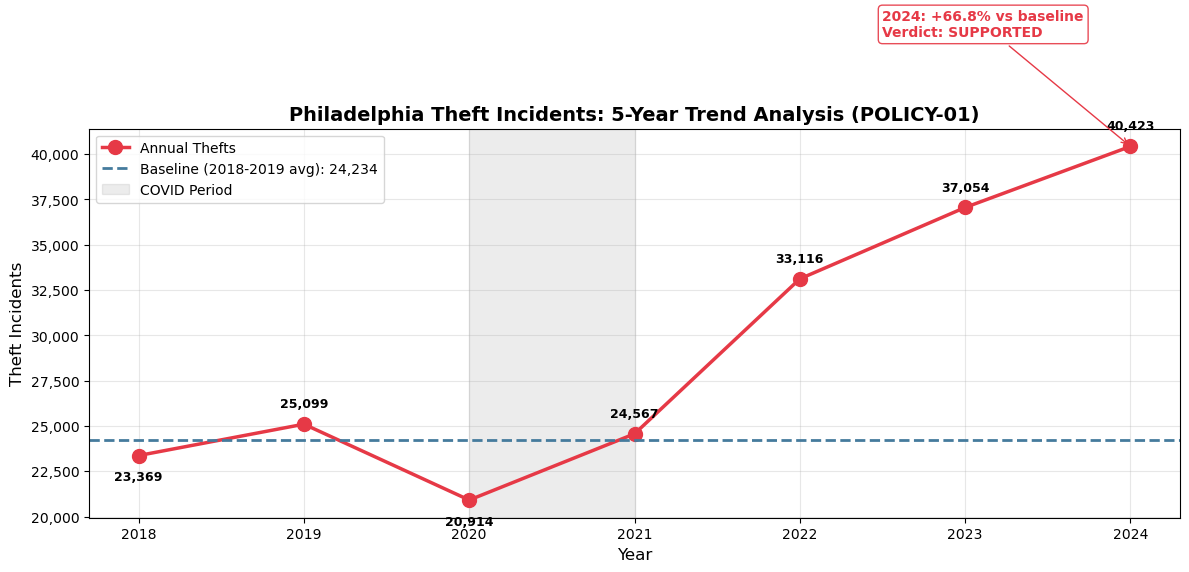

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot trend line
years = annual_counts['year']
counts = annual_counts['count']

ax.plot(years, counts, marker='o', markersize=10, linewidth=2.5, color='#E63946', label='Annual Thefts')
ax.axhline(y=baseline, color='#457B9D', linestyle='--', linewidth=2, 
           label=f'Baseline ({baseline_years[0]}-{baseline_years[-1]} avg): {baseline:,.0f}')

# Shade COVID period
ax.axvspan(2020, 2021, alpha=0.15, color='gray', label='COVID Period')

# Annotations for each year
for _, row in annual_counts.iterrows():
    offset = 12 if row['count'] > baseline else -18
    ax.annotate(f"{row['count']:,.0f}", 
               (row['year'], row['count']),
               textcoords="offset points", xytext=(0, offset),
               ha='center', fontsize=9, fontweight='bold')

# Highlight latest year vs baseline
verdict_threshold = config.retail_theft['verdict_threshold']
verdict = "SUPPORTED" if (latest_vs_baseline / 100) > verdict_threshold else "NOT SUPPORTED"
verdict_color = '#E63946' if verdict == "SUPPORTED" else '#2A9D8F'

ax.annotate(f"{latest_year}: {latest_vs_baseline:+.1f}% vs baseline\nVerdict: {verdict}",
           xy=(latest_year, latest_count), 
           xytext=(latest_year - 1.5, latest_count * 1.15),
           fontsize=10, fontweight='bold', color=verdict_color,
           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor=verdict_color, alpha=0.9),
           arrowprops=dict(arrowstyle='->', color=verdict_color))

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Theft Incidents', fontsize=12)
ax.set_title('Philadelphia Theft Incidents: 5-Year Trend Analysis (POLICY-01)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xticks(years)

# Format y-axis with commas
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'retail_theft_trend.png', dpi=300, bbox_inches='tight')
artifacts.append(('retail_theft_trend.png', 'Theft trend visualization'))
print(f"Saved: {REPORTS_DIR / 'retail_theft_trend.png'}")
plt.show()

## 4. Monthly Pattern Analysis

Saved: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/retail_theft_monthly_heatmap.png


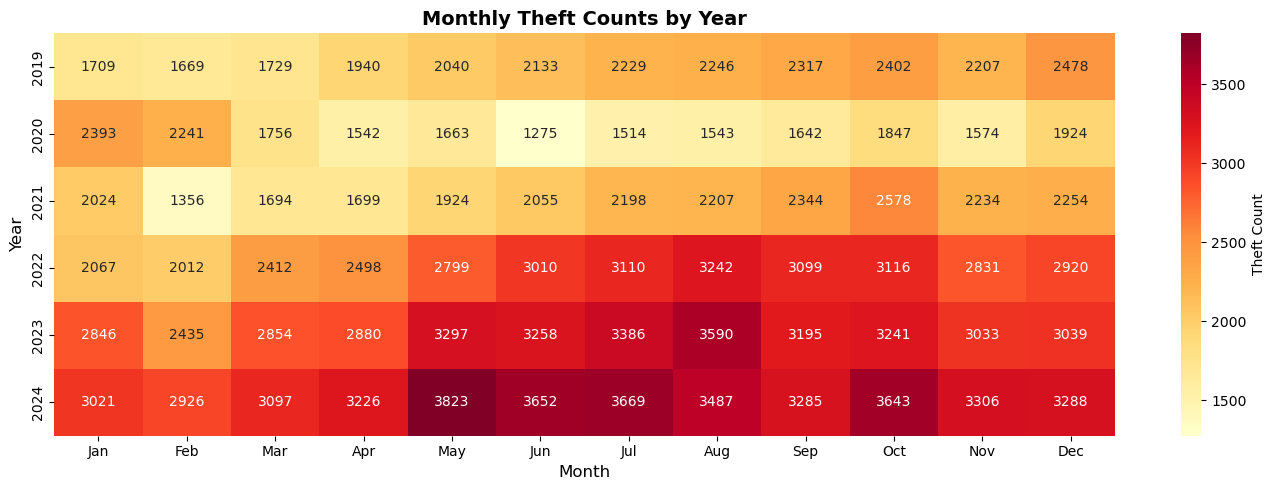

In [9]:
# Monthly patterns to identify seasonal effects
df_theft['month'] = df_theft['dispatch_date'].dt.month

# Filter to analysis years for heatmap
monthly_counts = df_theft[df_theft['year'].isin(analysis_years)]\
    .groupby(['year', 'month']).size().unstack(fill_value=0)

# Heatmap of monthly patterns
fig, ax = plt.subplots(figsize=(14, 5))
sns.heatmap(monthly_counts, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
            ax=ax, cbar_kws={'label': 'Theft Count'})
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Year', fontsize=12)
ax.set_title('Monthly Theft Counts by Year', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'retail_theft_monthly_heatmap.png', dpi=300, bbox_inches='tight')
artifacts.append(('retail_theft_monthly_heatmap.png', 'Monthly theft heatmap'))
print(f"Saved: {REPORTS_DIR / 'retail_theft_monthly_heatmap.png'}")
plt.show()

In [10]:
# Average by month across analysis years
monthly_avg = df_theft[df_theft['year'].isin(analysis_years)]\
    .groupby('month').size() / len(analysis_years)

# Holiday shopping season (Nov-Dec) vs rest of year
holiday_avg = monthly_avg.loc[[11, 12]].mean()
non_holiday_avg = monthly_avg.drop([11, 12]).mean()
holiday_premium = (holiday_avg / non_holiday_avg - 1) * 100

# Peak month identification
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
peak_month = month_names[monthly_avg.idxmax() - 1]
peak_count = monthly_avg.max()

print("Seasonal Analysis:")
print(f"  - Holiday season (Nov-Dec) premium: {holiday_premium:+.1f}%")
print(f"  - Peak month: {peak_month} with avg {peak_count:,.0f} incidents")
print(f"  - Holiday avg: {holiday_avg:,.0f} incidents/month")
print(f"  - Non-holiday avg: {non_holiday_avg:,.0f} incidents/month")

Seasonal Analysis:
  - Holiday season (Nov-Dec) premium: +3.6%
  - Peak month: Oct with avg 2,804 incidents
  - Holiday avg: 2,591 incidents/month
  - Non-holiday avg: 2,501 incidents/month


## 5. Verdict Determination

In [11]:
verdict_threshold = config.retail_theft['verdict_threshold']
pct_increase = latest_vs_baseline / 100

if pct_increase > verdict_threshold:
    verdict = "SUPPORTED"
    verdict_text = f"The data **supports** a significant increase in theft incidents. Theft has increased {latest_vs_baseline:+.1f}% from the pre-COVID baseline, exceeding the {verdict_threshold*100:.0f}% threshold."
else:
    verdict = "NOT SUPPORTED"
    verdict_text = f"The data **does not support** a significant increase in theft incidents. While theft has changed {latest_vs_baseline:+.1f}% from baseline, this is below the {verdict_threshold*100:.0f}% threshold."

print("\n" + "="*60)
print(f"VERDICT: {verdict}")
print("="*60)
print(f"\nBaseline ({baseline_years[0]}-{baseline_years[-1]}): {baseline:,.0f} thefts/year")
print(f"Latest year ({latest_year}): {latest_count:,.0f} thefts/year")
print(f"Change from baseline: {latest_vs_baseline:+.1f}%")
print(f"Threshold for 'supported': >{verdict_threshold*100:.0f}%")
print(f"\n{verdict_text}")


VERDICT: SUPPORTED

Baseline (2018-2019): 24,234 thefts/year
Latest year (2024): 40,423 thefts/year
Change from baseline: +66.8%
Threshold for 'supported': >25%

The data **supports** a significant increase in theft incidents. Theft has increased +66.8% from the pre-COVID baseline, exceeding the 25% threshold.


## 6. Export Reports

In [12]:
# Build year-by-year table
table_rows = ""
for _, row in annual_counts.iterrows():
    yoy = f"{row['yoy_change']:+.1f}%" if pd.notna(row['yoy_change']) else "—"
    vsb = f"{row['vs_baseline']:+.1f}%" if pd.notna(row['vs_baseline']) else "—"
    table_rows += f"| {int(row['year'])} | {row['count']:,} | {yoy} | {vsb} |\n"

report_content = f"""# Retail Theft Trend Analysis Report (POLICY-01)

## Executive Summary

**Verdict: {verdict}**

{verdict_text}

## Key Findings

### 5-Year Trend
- **Baseline average** ({baseline_years[0]}-{baseline_years[-1]}): **{baseline:,.0f}** thefts/year
- **Latest complete year** ({latest_year}): **{latest_count:,.0f}** thefts/year
- **Change from baseline**: **{latest_vs_baseline:+.1f}%**

### Year-by-Year Breakdown

| Year | Count | YoY Change | vs Baseline |
|------|-------|------------|-------------|
{table_rows}
### Seasonal Patterns
- Holiday shopping season (Nov-Dec) shows **{holiday_premium:+.1f}%** premium over other months
- Peak month: **{peak_month}** with average {peak_count:,.0f} incidents

### COVID-19 Impact
- 2020 saw a significant dip due to pandemic lockdowns and business closures
- Post-COVID recovery began in 2021 and accelerated through 2023-2024

## Methodology

- **Data source**: Philadelphia Police Department crime incident data
- **Category**: "Thefts" (`text_general_code = 'Thefts'`)
- **UCR Code**: 600 (Theft/Larceny)
- **Analysis period**: {analysis_years[0]}-{analysis_years[-1]}
- **Baseline period**: {baseline_years[0]}-{baseline_years[-1]}
- **Verdict threshold**: >{verdict_threshold*100:.0f}% increase from baseline = "SUPPORTED"

## Caveats

1. **Proxy measure**: This analysis uses "Thefts" as a proxy for retail theft. The data does not distinguish between retail theft, shoplifting, and other theft categories.
2. **Reporting changes**: Changes in reporting practices may affect year-over-year comparisons.
3. **COVID distortion**: The 2020-2021 pandemic period created abnormal conditions that may distort trend analysis.
4. **Population changes**: This is a raw count analysis; per-capita rates may differ.

## Visualizations

- `retail_theft_trend.png` - 5-year trend with baseline comparison
- `retail_theft_monthly_heatmap.png` - Monthly patterns by year

---
*Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}*  
*Notebook: retail_theft_trend.ipynb*  
*Requirement: POLICY-01*
"""

with open(REPORTS_DIR / 'retail_theft_verdict.md', 'w') as f:
    f.write(report_content)

artifacts.append(('retail_theft_verdict.md', 'Verdict summary report'))
print(f"Saved: {REPORTS_DIR / 'retail_theft_verdict.md'}")

Saved: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/retail_theft_verdict.md


In [13]:
# Export annual counts CSV
annual_counts.to_csv(REPORTS_DIR / 'retail_theft_annual.csv', index=False)
artifacts.append(('retail_theft_annual.csv', 'Annual theft counts'))
print(f"Saved: {REPORTS_DIR / 'retail_theft_annual.csv'}")

# Display final table
print("\nAnnual Theft Summary:")
display_df = annual_counts.copy()
display_df['yoy_change'] = display_df['yoy_change'].apply(lambda x: f"{x:+.1f}%" if pd.notna(x) else "—")
display_df['vs_baseline'] = display_df['vs_baseline'].apply(lambda x: f"{x:+.1f}%" if pd.notna(x) else "—")
print(display_df.to_string(index=False))

Saved: /Users/dustinober/Projects/Crime Incidents Philadelphia/reports/retail_theft_annual.csv

Annual Theft Summary:
 year  count yoy_change vs_baseline
 2018  23369          —       -3.6%
 2019  25099      +7.4%       +3.6%
 2020  20914     -16.7%      -13.7%
 2021  24567     +17.5%       +1.4%
 2022  33116     +34.8%      +36.7%
 2023  37054     +11.9%      +52.9%
 2024  40423      +9.1%      +66.8%


## 7. Notebook Summary

In [14]:
print("\n" + "="*60)
print("NOTEBOOK COMPLETE: Retail Theft Trend Analysis (POLICY-01)")
print("="*60)
print(f"\nVerdict: {verdict}")
print(f"Baseline: {baseline:,.0f} thefts/year ({baseline_years[0]}-{baseline_years[-1]})")
print(f"{latest_year}: {latest_count:,.0f} thefts ({latest_vs_baseline:+.1f}% vs baseline)")
print(f"\nArtifacts generated:")
for name, desc in artifacts:
    print(f"  - {name}: {desc}")
print(f"\nRuntime: {time.time() - RUNTIME_START:.1f} seconds")


NOTEBOOK COMPLETE: Retail Theft Trend Analysis (POLICY-01)

Verdict: SUPPORTED
Baseline: 24,234 thefts/year (2018-2019)
2024: 40,423 thefts (+66.8% vs baseline)

Artifacts generated:
  - retail_theft_trend.png: Theft trend visualization
  - retail_theft_monthly_heatmap.png: Monthly theft heatmap
  - retail_theft_verdict.md: Verdict summary report
  - retail_theft_annual.csv: Annual theft counts

Runtime: 3.4 seconds
